## Importing the relevant packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats.distributions import chi2 
from math import sqrt
import seaborn as sns
sns.set()

In [2]:
from influxdb_client import InfluxDBClient

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Importing the Data and Pre-processing 

In [4]:
#Auth parameters
my_token = "yaKfFeAsha8tNAZxvYeZBMmq-khO8tz-6Ut_PARgohiWzeW2j8BB86ND33Qbq7hR8bylmOROPQAUr-7M103_Yw=="
my_org = "iot-org"
bucket = "iot-demo"
client = InfluxDBClient(url="http://192.168.1.100:9999", token=my_token, org=my_org, debug=False)

In [5]:
queryTemperature = '''
from(bucket: "iot-demo")
  |> range(start: -5d, stop: now())
  |> filter(fn: (r) => r["_measurement"] == "temperature")
  |> filter(fn: (r) => r["device"] == "RoomWeather")
  |> aggregateWindow(every: 10m, fn: median)
  '''

queryHumidity = '''
from(bucket: "iot-demo")
  |> range(start: -5d, stop: now())
  |> filter(fn: (r) => r["_measurement"] == "humidity")
  |> filter(fn: (r) => r["device"] == "RoomWeather")
  |> aggregateWindow(every: 10m, fn: median)
  '''

queryPressure = '''
from(bucket: "iot-demo")
  |> range(start: -5d, stop: now())
  |> filter(fn: (r) => r["_measurement"] == "pressure")
  |> filter(fn: (r) => r["device"] == "RoomWeather")
  |> aggregateWindow(every: 10m, fn: median)
  '''

In [6]:
#Query InfluxDB and return a Dataframe
dfTemp = client.query_api().query_data_frame(org=my_org, query=queryTemperature)
dfHum = client.query_api().query_data_frame(org=my_org, query=queryHumidity)
dfPress = client.query_api().query_data_frame(org=my_org, query=queryPressure)

In [7]:
dfTemp.head()

,result,table,_start,_stop,_field,_measurement,device,location,_value,_time
0,_result,0,2020-07-07 12:49:32.983387+00:00,2020-07-12 12:49:32.983387+00:00,value,temperature,RoomWeather,ubuntu,29.45,2020-07-07 12:50:00+00:00
1,_result,0,2020-07-07 12:49:32.983387+00:00,2020-07-12 12:49:32.983387+00:00,value,temperature,RoomWeather,ubuntu,29.50,2020-07-07 13:00:00+00:00
2,_result,0,2020-07-07 12:49:32.983387+00:00,2020-07-12 12:49:32.983387+00:00,value,temperature,RoomWeather,ubuntu,NaN,2020-07-07 13:10:00+00:00
3,_result,0,2020-07-07 12:49:32.983387+00:00,2020-07-12 12:49:32.983387+00:00,value,temperature,RoomWeather,ubuntu,29.60,2020-07-07 13:20:00+00:00
4,_result,0,2020-07-07 12:49:32.983387+00:00,2020-07-12 12:49:32.983387+00:00,value,temperature,RoomWeather,ubuntu,29.70,2020-07-07 13:30:00+00:00


In [8]:
dfHum.head()

,result,table,_start,_stop,_field,_measurement,device,location,_value,_time
0,_result,0,2020-07-07 12:49:35.708493+00:00,2020-07-12 12:49:35.708493+00:00,value,humidity,RoomWeather,ubuntu,NaN,2020-07-07 12:50:00+00:00
1,_result,0,2020-07-07 12:49:35.708493+00:00,2020-07-12 12:49:35.708493+00:00,value,humidity,RoomWeather,ubuntu,45.0,2020-07-07 13:00:00+00:00
2,_result,0,2020-07-07 12:49:35.708493+00:00,2020-07-12 12:49:35.708493+00:00,value,humidity,RoomWeather,ubuntu,44.8,2020-07-07 13:10:00+00:00
3,_result,0,2020-07-07 12:49:35.708493+00:00,2020-07-12 12:49:35.708493+00:00,value,humidity,RoomWeather,ubuntu,44.8,2020-07-07 13:20:00+00:00
4,_result,0,2020-07-07 12:49:35.708493+00:00,2020-07-12 12:49:35.708493+00:00,value,humidity,RoomWeather,ubuntu,44.5,2020-07-07 13:30:00+00:00


In [9]:
dfPress.head()

,result,table,_start,_stop,_field,_measurement,device,location,_value,_time
0,_result,0,2020-07-07 12:49:38.556177+00:00,2020-07-12 12:49:38.556177+00:00,value,pressure,RoomWeather,ubuntu,NaN,2020-07-07 12:50:00+00:00
1,_result,0,2020-07-07 12:49:38.556177+00:00,2020-07-12 12:49:38.556177+00:00,value,pressure,RoomWeather,ubuntu,NaN,2020-07-07 13:00:00+00:00
2,_result,0,2020-07-07 12:49:38.556177+00:00,2020-07-12 12:49:38.556177+00:00,value,pressure,RoomWeather,ubuntu,NaN,2020-07-07 13:10:00+00:00
3,_result,0,2020-07-07 12:49:38.556177+00:00,2020-07-12 12:49:38.556177+00:00,value,pressure,RoomWeather,ubuntu,NaN,2020-07-07 13:20:00+00:00
4,_result,0,2020-07-07 12:49:38.556177+00:00,2020-07-12 12:49:38.556177+00:00,value,pressure,RoomWeather,ubuntu,NaN,2020-07-07 13:30:00+00:00


In [10]:
df = pd.DataFrame(dfTemp['_time']).rename(columns={'_time':'time'})
df['temperature'] = dfTemp['_value']
df['humidity'] = dfHum['_value']
df['pressure'] = dfPress['_value']
df = df.set_index('time')
df.head()

,temperature,humidity,pressure
time,,,
2020-07-07 12:50:00+00:00,29.45,NaN,NaN
2020-07-07 13:00:00+00:00,29.50,45.0,NaN
2020-07-07 13:10:00+00:00,NaN,44.8,NaN
2020-07-07 13:20:00+00:00,29.60,44.8,NaN
2020-07-07 13:30:00+00:00,29.70,44.5,NaN


# Fill NaN values

In [11]:
df['temperature'] = df['temperature'].fillna(method='backfill')
df['humidity'] = df['humidity'].fillna(method='backfill')
df['pressure'] = df['pressure'].fillna(method='backfill').fillna(method='ffill')

In [12]:
df_dim = len(df)

In [13]:
print(df['temperature'].isnull().sum())
print(df['humidity'].isnull().sum())
print(df['pressure'].isnull().sum())

0
0
0


# Split the dataset

In [14]:
# divide in train e test
size = int(len(df)*0.8)
df_train, df_test = df.iloc[:size], df.iloc[size:]

# Dickey–Fuller test

In [15]:
sts.adfuller(df.temperature) # stazionaria

(-3.5072707828497167,
 0.0078023166236782775,
 17,
 703,
 {'1%': -3.4396861854831964,
  '5%': -2.865660062273053,
  '10%': -2.5689640195342456},
 -927.2760582210278)

In [16]:
sts.adfuller(df.humidity) # non stazionaria

(-1.3018390526379338,
 0.6283305254083775,
 1,
 719,
 {'1%': -3.439477677285233,
  '5%': -2.865568186630048,
  '10%': -2.5689150720653977},
 196.50311140150984)

In [17]:
sts.adfuller(df.pressure) # non stazionaria

(-0.37493023303065454,
 0.9142011349698642,
 2,
 718,
 {'1%': -3.439490435810785,
  '5%': -2.8655738086413374,
  '10%': -2.568918067209286},
 -48.224009175543415)

## The LLR Test

In [18]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

## Auto Correlation Function (ACF)

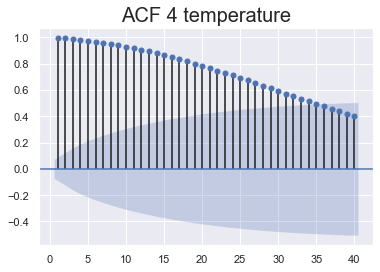

In [19]:
sgt.plot_acf(df.temperature, zero = False, lags = 40)
plt.title("ACF 4 temperature", size = 20)
plt.show()

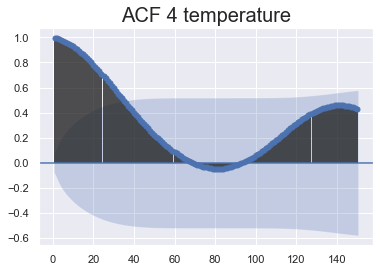

In [29]:
sgt.plot_acf(df.temperature, zero = False, lags = 150)
plt.title("ACF 4 temperature", size = 20)
plt.show()

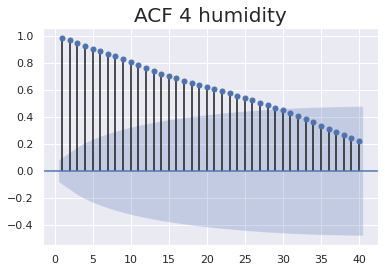

In [36]:
sgt.plot_acf(df.humidity, zero = False, lags = 40)
plt.title("ACF 4 humidity", size = 20)
plt.show()

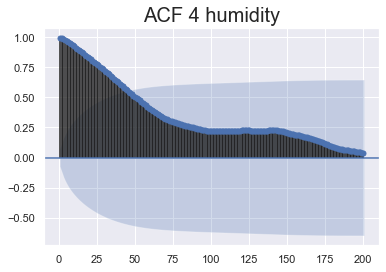

In [27]:
sgt.plot_acf(df.humidity, zero = False, lags = 200)
plt.title("ACF 4 humidity", size = 20)
plt.show()

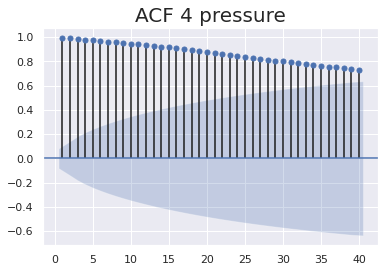

In [37]:
sgt.plot_acf(df.pressure, zero = False, lags = 40)
plt.title("ACF 4 pressure", size = 20)
plt.show()

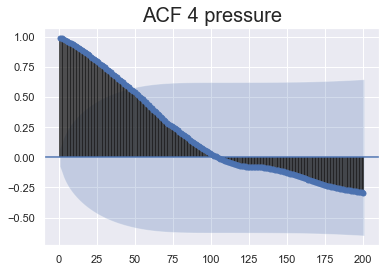

In [28]:
sgt.plot_acf(df.pressure, zero = False, lags = 200)
plt.title("ACF 4 pressure", size = 20)
plt.show()

## Partial Auto Correlation Function (PACF)

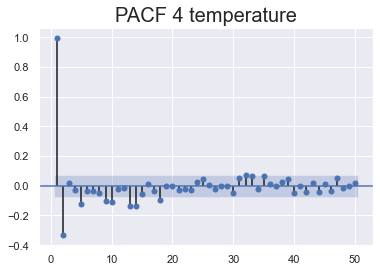

In [36]:
sgt.plot_pacf(df.temperature, lags = 50, alpha = 0.05, zero = False, method = ('ols'))
plt.title("PACF 4 temperature", size = 20)
plt.show()

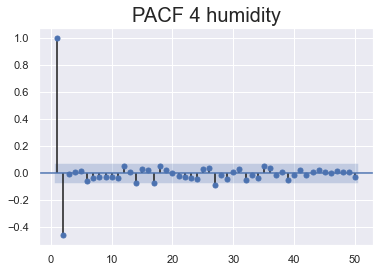

In [37]:
sgt.plot_pacf(df.humidity, lags = 50, alpha = 0.05, zero = False, method = ('ols'))
plt.title("PACF 4 humidity", size = 20)
plt.show()

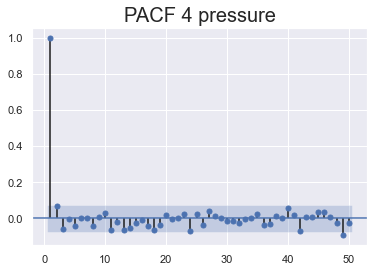

In [38]:
sgt.plot_pacf(df.pressure, lags = 50, alpha = 0.05, zero = False, method = ('ols'))
plt.title("PACF 4 pressure", size = 20)
plt.show()

# Temperature

## AR

In [87]:
model_t_ar_1 = ARIMA(df.temperature, order=(1,0,0))
results_t_ar_1 = model_t_ar_1.fit()
print(results_t_ar_1.summary())
model_t_ar_2 = ARIMA(df.temperature, order=(2,0,0))
results_t_ar_2 = model_t_ar_2.fit()
print(results_t_ar_2.summary())
model_t_ar_3 = ARIMA(df.temperature, order=(3,0,0))
results_t_ar_3 = model_t_ar_3.fit()
print(results_t_ar_3.summary())

                              ARMA Model Results                              
Dep. Variable:            temperature   No. Observations:                  721
Model:                     ARMA(1, 0)   Log Likelihood                 404.777
Method:                       css-mle   S.D. of innovations              0.138
Date:                Sun, 12 Jul 2020   AIC                           -803.554
Time:                        16:13:15   BIC                           -789.812
Sample:                             0   HQIC                          -798.249
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                30.0202      1.053     28.519      0.000      27.957      32.083
ar.L1.temperature     0.9963      0.003    396.752      0.000       0.991       1.001
                        

In [88]:
print("\nLLR test AR(1)-AR(2) = " + str(LLR_test(results_t_ar_1, results_t_ar_2)))


LLR test AR(1)-AR(2) = 0.0


### Analysis of Residuals AR

(-4.028964807529955, 0.0012662108174691653, 13, 707, {'1%': -3.439633170421852, '5%': -2.8656367026715337, '10%': -2.5689515744354794}, -921.8285541853827)


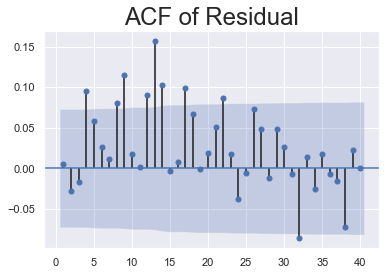

In [89]:
df['res_temp'] = results_t_ar_2.resid
print(sts.adfuller(df.res_temp))
sgt.plot_acf(df.res_temp, zero = False, lags = 40)
plt.title("ACF of Residual", size=24)
plt.show()

In [90]:
del df['res_temp']

## MA

In [91]:
model_t_ma_1 = ARMA(df.temperature, order=(0,1))
results_t_ma_1 = model_t_ma_1.fit()
print(results_t_ma_1.summary())

#model_t_ma_2 = ARIMA(df.temperature, order=(0,0,2))
#results_t_ma_2 = model_t_ma_2.fit(start_ar_lags=100)
#print(results_t_ma_2.summary())

                              ARMA Model Results                              
Dep. Variable:            temperature   No. Observations:                  721
Model:                     ARMA(0, 1)   Log Likelihood                -963.062
Method:                       css-mle   S.D. of innovations              0.918
Date:                Sun, 12 Jul 2020   AIC                           1932.125
Time:                        16:13:23   BIC                           1945.867
Sample:                             0   HQIC                          1937.430
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                30.4585      0.068    451.131      0.000      30.326      30.591
ma.L1.temperature     0.9757      0.008    121.047      0.000       0.960       0.991
                        

## ARMA

In [92]:
print("\nARMA(1,1)")
reults_t_ar_1_ma_1 = ARMA(df.temperature, order=(1,1)).fit()
print(reults_t_ar_1_ma_1.summary())

print("\nARMA(2,1)") #NON SIGNIFICATIVO
reults_t_ar_2_ma_1 = ARMA(df.temperature, order=(2,1)).fit()
print(reults_t_ar_2_ma_1.summary())

print("\nARMA(1,2)")
reults_t_ar_1_ma_2 = ARMA(df.temperature, order=(1,2)).fit()
print(reults_t_ar_1_ma_2.summary())

print("\nARMA(2,2)") #NON SIGNIFICATIVO
reults_t_ar_2_ma_2 = ARMA(df.temperature, order=(2,2)).fit()
print(reults_t_ar_2_ma_2.summary())


ARMA(1,1)
                              ARMA Model Results                              
Dep. Variable:            temperature   No. Observations:                  721
Model:                     ARMA(1, 1)   Log Likelihood                 444.198
Method:                       css-mle   S.D. of innovations              0.130
Date:                Sun, 12 Jul 2020   AIC                           -880.396
Time:                        16:13:27   BIC                           -862.074
Sample:                             0   HQIC                          -873.323
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                30.1060      0.968     31.095      0.000      28.208      32.004
ar.L1.temperature     0.9946      0.003    307.571      0.000       0.988       1.001
ma.L1.tempera

In [93]:
print("ARMA(1,1):  \t LL = ", reults_t_ar_1_ma_1.llf, "\t AIC = ", reults_t_ar_1_ma_1.aic)
#print("ARMA(2,1):  \t LL = ", reults_t_ar_2_ma_1.llf, "\t AIC = ", reults_t_ar_2_ma_1.aic)
print("ARMA(1,2):  \t LL = ", reults_t_ar_1_ma_2.llf, "\t AIC = ", reults_t_ar_1_ma_2.aic)
print("ARMA(2,2):  \t LL = ", reults_t_ar_2_ma_2.llf, "\t AIC = ", reults_t_ar_2_ma_2.aic)

ARMA(1,1):  	 LL =  444.1981671338526 	 AIC =  -880.3963342677052
ARMA(1,2):  	 LL =  447.6085660653937 	 AIC =  -885.2171321307874
ARMA(2,2):  	 LL =  462.0474701315072 	 AIC =  -912.0949402630145


In [95]:
print("\nAR(2) vs ARMA(1,1) ",LLR_test(results_t_ar_2, reults_t_ar_1_ma_1))
#print("\nAR(2) vs ARMA(2,1) ",LLR_test(results_t_ar_2, reults_t_ar_2_ma_1))
print("\nAR(2) vs ARMA(1,2) ",LLR_test(results_t_ar_2, reults_t_ar_1_ma_2))
print("\nAR(2) vs ARMA(2,2) ",LLR_test(results_t_ar_2, reults_t_ar_2_ma_2))


AR(2) vs ARMA(1,1)  1.0

AR(2) vs ARMA(1,2)  0.441

AR(2) vs ARMA(2,2)  0.0


### Analysis of Residuals ARMA

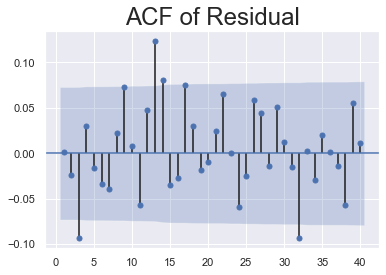

In [100]:
sgt.plot_acf(reults_t_ar_2_ma_2.resid.iloc[:][1:], zero = False, lags = 40)
plt.title("ACF of Residual", size=24)
plt.show()

## ARIMA

In [102]:
print("\nARIMA(1,1,1)") #NON SIGNIFICATIVO
results_t_ar_1_i_1_ma_1 = ARIMA(df.temperature, order=(1,1,1)).fit()
print(results_t_ar_1_i_1_ma_1.summary())

print("\nARIMA(2,1,1)") #NON SIGNIFICATIVO
results_t_ar_2_i_1_ma_1 = ARIMA(df.temperature, order=(2,1,1)).fit()
print(results_t_ar_2_i_1_ma_1.summary())

print("\nARIMA(1,1,2)")
results_t_ar_1_i_1_ma_2 = ARIMA(df.temperature, order=(1,1,2)).fit()
print(results_t_ar_1_i_1_ma_2.summary())

print("\nARIMA(2,1,2)") #NON SIGNIFICATIVO
results_t_ar_2_i_1_ma_2 = ARIMA(df.temperature, order=(2,1,2)).fit()
print(results_t_ar_2_i_1_ma_2.summary())

############################

print("\nARIMA(1,2,1)")
results_t_ar_1_i_2_ma_1 = ARIMA(df.temperature, order=(1,2,1)).fit()
print(results_t_ar_1_i_2_ma_1.summary())

print("\nARIMA(2,2,1)")
results_t_ar_2_i_2_ma_1 = ARIMA(df.temperature, order=(2,2,1)).fit()
print(results_t_ar_2_i_2_ma_1.summary())

print("\nARIMA(1,2,2)") #NON SIGNIFICATIVO
results_t_ar_1_i_2_ma_2 = ARIMA(df.temperature, order=(1,2,2)).fit()
print(results_t_ar_1_i_2_ma_2.summary())

print("\nARIMA(2,2,2)")
results_t_ar_2_i_2_ma_2 = ARIMA(df.temperature, order=(2,2,2)).fit()
print(results_t_ar_2_i_2_ma_2.summary())


ARIMA(1,1,1)
                             ARIMA Model Results                              
Dep. Variable:          D.temperature   No. Observations:                  720
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 448.001
Method:                       css-mle   S.D. of innovations              0.130
Date:                Sun, 12 Jul 2020   AIC                           -888.002
Time:                        16:26:57   BIC                           -869.685
Sample:                             1   HQIC                          -880.931
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -4.854e-05      0.007     -0.007      0.995      -0.014       0.014
ar.L1.D.temperature     0.2698      0.108      2.505      0.012       0.059       0.481
ma

                             ARIMA Model Results                              
Dep. Variable:         D2.temperature   No. Observations:                  719
Model:                 ARIMA(2, 2, 1)   Log Likelihood                 452.506
Method:                       css-mle   S.D. of innovations              0.129
Date:                Sun, 12 Jul 2020   AIC                           -895.013
Time:                        16:26:59   BIC                           -872.124
Sample:                             2   HQIC                          -886.176
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -2.649e-05      0.000     -0.058      0.953      -0.001       0.001
ar.L1.D2.temperature     0.2484      0.040      6.225      0.000       0.170       0.327
ar.L2.D2.tem

In [105]:
print("ARMA(1,1,1):  \t LL = ", results_t_ar_1_i_1_ma_1.llf, "\t AIC = ", results_t_ar_1_i_1_ma_1.aic)
#print("ARMA(2,1,1):  \t LL = ", results_t_ar_2_i_1_ma_1.llf, "\t AIC = ", results_t_ar_2_i_1_ma_1.aic)
print("ARMA(1,1,2):  \t LL = ", results_t_ar_1_i_1_ma_2.llf, "\t AIC = ", results_t_ar_1_i_1_ma_2.aic)
#print("ARMA(2,1,2):  \t LL = ", results_t_ar_2_i_1_ma_2.llf, "\t AIC = ", results_t_ar_2_i_1_ma_2.aic)

print("ARMA(1,2,1):  \t LL = ", results_t_ar_1_i_2_ma_1.llf, "\t AIC = ", results_t_ar_1_i_2_ma_1.aic)
print("ARMA(2,2,1):  \t LL = ", results_t_ar_2_i_2_ma_1.llf, "\t AIC = ", results_t_ar_2_i_2_ma_1.aic)
#print("ARMA(1,2,2):  \t LL = ", results_t_ar_1_i_2_ma_2.llf, "\t AIC = ", results_t_ar_1_i_2_ma_2.aic)
print("ARMA(2,2,2):  \t LL = ", results_t_ar_2_i_2_ma_2.llf, "\t AIC = ", results_t_ar_2_i_2_ma_2.aic)

ARMA(1,1,1):  	 LL =  448.00097927699096 	 AIC =  -888.0019585539819
ARMA(1,1,2):  	 LL =  458.05059962361713 	 AIC =  -906.1011992472343
ARMA(1,2,1):  	 LL =  448.8776404774204 	 AIC =  -889.7552809548408
ARMA(2,2,1):  	 LL =  452.5064213642505 	 AIC =  -895.012842728501
ARMA(2,2,2):  	 LL =  457.19980758514805 	 AIC =  -902.3996151702961


In [108]:
#Ha vinto (1,1,2) e secondo LLR vale la pena di utilizzarlo
print("\nAR(2) vs ARIMA(1,1,2) ",LLR_test(results_t_ar_2, results_t_ar_1_i_1_ma_2))
print("\nARMA(2,2) vs ARIMA(1,1,2) ",LLR_test(reults_t_ar_2_ma_2, results_t_ar_1_i_1_ma_2))
print("\nARMA(1,1,1) vs ARIMA(1,1,2) ",LLR_test(results_t_ar_1_i_1_ma_1, results_t_ar_1_i_1_ma_2))


AR(2) vs ARIMA(1,1,2)  0.0

ARMA(2,2) vs ARIMA(1,1,2)  1.0

ARMA(1,1,1) vs ARIMA(1,1,2)  0.0


### Residuals of the ARIMA(1,1,2)

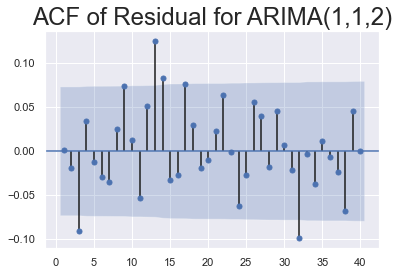

In [123]:
#df['res_temp'] = results_t_ar_3_i_1_ma_1.resid.iloc[:] #Mettere il migliore tra gli ARMA
#print(sts.adfuller(df.res_temp))
sgt.plot_acf(results_t_ar_1_i_1_ma_2.resid.iloc[:][1:], zero = False, lags = 40)
plt.title("ACF of Residual for ARIMA(1,1,2)", size=24)
plt.show()

## ARIMAX

In [127]:
results_t_ar_2_i_0_ma_2_X_h = ARIMA(df.temperature, exog = df.humidity, order=(2,0,2)).fit() #ORDER?
print(results_t_ar_2_i_0_ma_2_X_h.summary())
results_t_ar_2_i_0_ma_2_X_p = ARIMA(df.temperature, exog = df.pressure, order=(2,1,2)).fit() #ORDER?
print(results_t_ar_2_i_0_ma_2_X_p.summary())
results_t_ar_2_i_0_ma_2_X_hp = ARIMA(df.temperature, exog = df[['pressure','humidity']], order=(2,1,2)).fit() #ORDER?
print(results_t_ar_2_i_0_ma_2_X_hp.summary())

                              ARMA Model Results                              
Dep. Variable:            temperature   No. Observations:                  721
Model:                     ARMA(2, 2)   Log Likelihood                 479.832
Method:                       css-mle   S.D. of innovations              0.123
Date:                Sun, 12 Jul 2020   AIC                           -945.664
Time:                        17:25:02   BIC                           -913.599
Sample:                             0   HQIC                          -933.286
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                35.4170      4.558      7.770      0.000      26.483      44.351
humidity             -0.1257      0.016     -7.770      0.000      -0.157      -0.094
ar.L1.temperature     1.

In [129]:
print("\nAR(2,2) vs ARIMAX(2,0,2) hum",LLR_test(reults_t_ar_2_ma_2, results_t_ar_2_i_0_ma_2_X_h))


AR(2,2) vs ARIMAX(2,0,2) hum 0.0


## SARIMAX

In [73]:
results_t_sarimax_h = SARIMAX(df.temperature, order=(3,1,1), seasonal_order = (2,0,1,int(df_dim/3))).fit() #ORDER? STAGIONALITY?
results_t_sarimax_h.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                         temperature   No. Observations:                  433
Model:             SARIMAX(3, 1, 1)x(2, 0, 1, 144)   Log Likelihood                 250.080
Date:                             Sat, 11 Jul 2020   AIC                           -484.160
Time:                                     17:20:09   BIC                           -451.613
Sample:                                          0   HQIC                          -471.310
                                             - 433                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3597      0.543     -0.662      0.508      -1.424       0.705
ar.L2          0.1983      0.168      1.181      0.238      -0.131       0.528
ar.L3         -0.0715      0.061     -1.179      0.238      -0.190       0.047
ma.L1          0.6882      0.544      1.265      0.206      -0.378       1.755
ar.S.L144      0.0208    793.555   2.62e-05      1.000   -1555.317    1555.359
ar.S.L288      0.0430     31.417      0.001      0.999     -61.533      61.619
ma.S.L144      0.0171    794.987   2.16e-05      1.000   -1558.128    1558.163
sigma2         0.0184      0.001     16.405      0.000       0.016       0.021
===================================================================================
Ljung-Box (Q):                       71.69   Jarque-Bera (JB):               712.00
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                             1.06
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
results_t_sarimax_p = SARIMAX(df.temperature, order=(3,1,1), seasonal_order = (2,0,1,5)).fit() #ORDER? STAGIONALITY?
results_t_sarimax_p.summary()

## Make predictions

In [ ]:
start_date = "..."
end_date = "..."

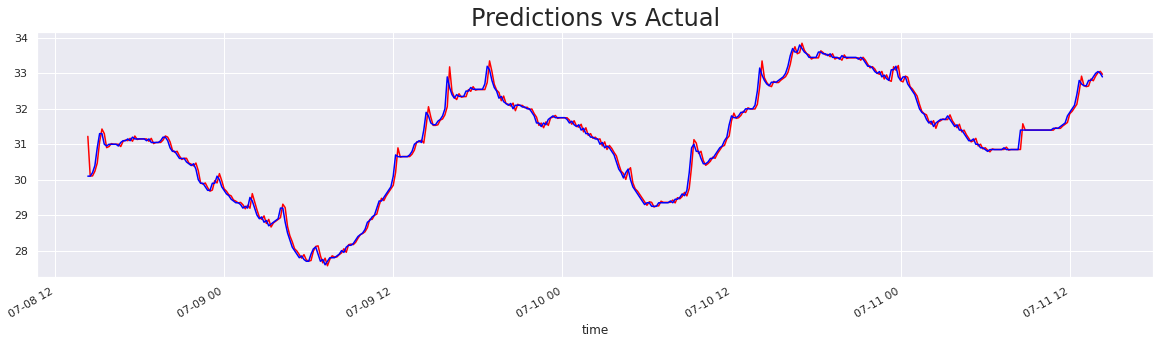

In [61]:
#AR
df_pred_t_ar_2 = results_t_ar_2.predict()
df_pred_t_ar_2.plot(figsize = (20,5), color = "red")
df.temperature.plot(color="blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

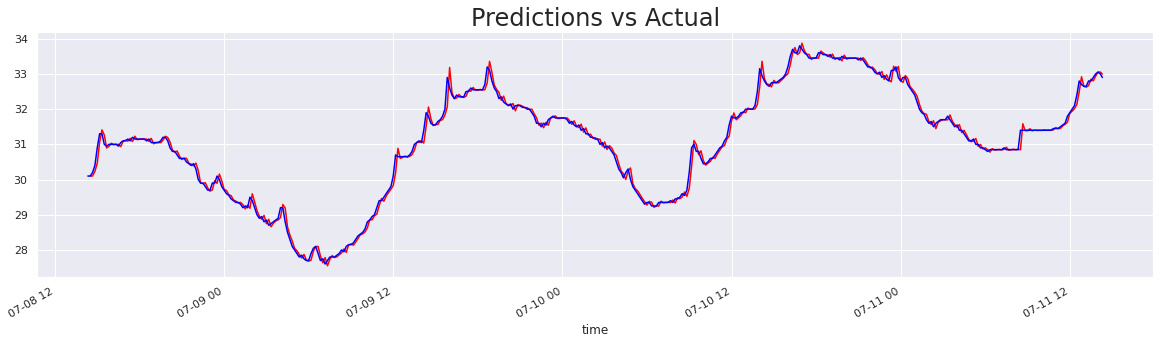

In [75]:
#SARIMAX
df_t_sarimax_h = results_t_sarimax_h.predict()
df_t_sarimax_h[1:].plot(figsize = (20,5), color = "red")
df.temperature.plot(color="blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

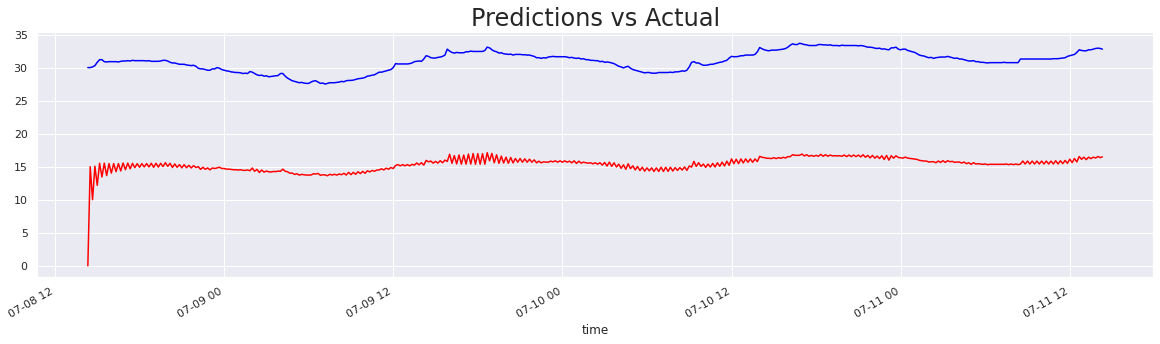

In [62]:
#MA
df_pred_t_ma_1 = results_t_ma_1.predict()
df_pred_t_ma_1.plot(figsize = (20,5), color = "red")
df.temperature.plot(color="blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

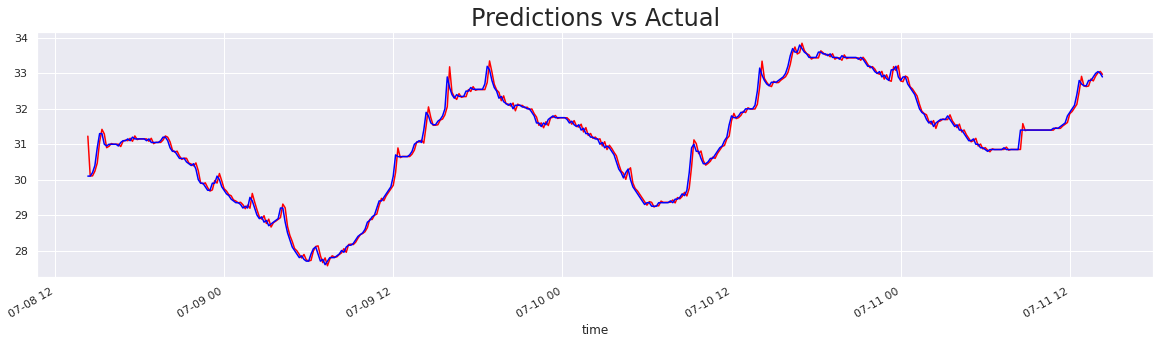

In [64]:
#ARMA
df_pred_t_ar_2_ma_1 = reults_t_ar_2_ma_1.predict()
df_pred_t_ar_2_ma_1.plot(figsize = (20,5), color = "red")
df.temperature.plot(color="blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

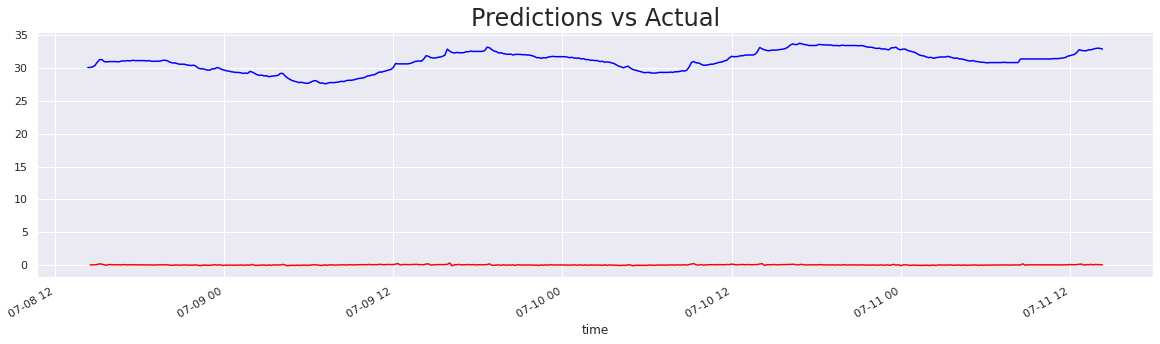

In [71]:
#ARIMA
df_pred_t_ar_3_i_1_ma_1 = results_t_ar_3_i_1_ma_1.predict()
df_pred_t_ar_3_i_1_ma_1.plot(figsize = (20,5), color = "red")
df.temperature.plot(color="blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

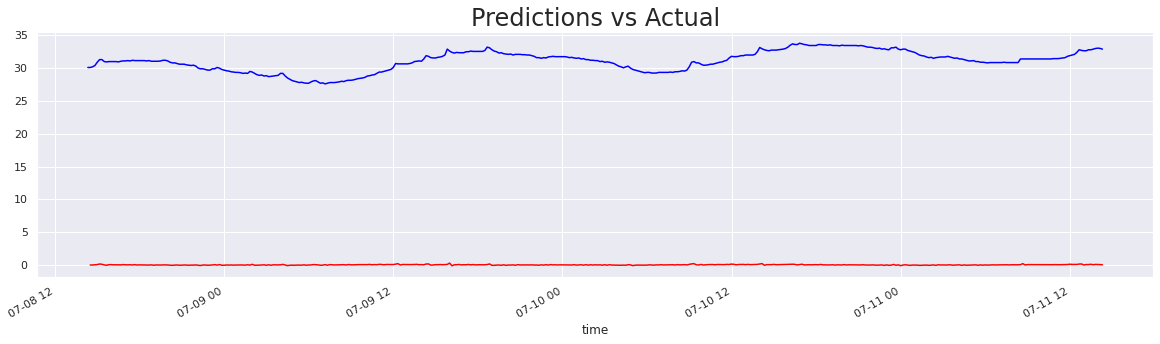

In [70]:
#ARIMAX
df_pred_t_ar_3_i_1_ma_1_X_h = results_t_ar_3_i_1_ma_1_X_h.predict()
df_pred_t_ar_3_i_1_ma_1_X_h.plot(figsize = (20,5), color = "red")
df.temperature.plot(color="blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

In [ ]:
#SARIMAX
results_t_sarimax_h = results_t_sarimax_h.predict(start = start_date, end = end_date)
results_t_sarimax_h[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ftse[start_date:end_date].plot(color="blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

# Humidity

In [47]:
model_h_ar_1 = ARIMA(df.humidity, order=(1,0,0))
results_h_ar_1 = model_h_ar_1.fit()
print(results_h_ar_1.summary())
model_h_ar_2 = ARIMA(df.humidity, order=(2,0,0))
results_h_ar_2 = model_h_ar_2.fit()
print(results_h_ar_2.summary())
model_h_ar_3 = ARIMA(df.humidity, order=(3,0,0))
results_h_ar_3 = model_h_ar_3.fit()
print(results_h_ar_3.summary())

                              ARMA Model Results                              
Dep. Variable:               humidity   No. Observations:                  721
Model:                     ARMA(1, 0)   Log Likelihood                -191.250
Method:                       css-mle   S.D. of innovations              0.314
Date:                Sun, 12 Jul 2020   AIC                            388.501
Time:                        15:19:44   BIC                            402.243
Sample:                             0   HQIC                           393.806
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             45.9139      3.115     14.737      0.000      39.808      52.020
ar.L1.humidity     0.9973      0.002    480.079      0.000       0.993       1.001
                                    

In [50]:
print("\nLLR test AR(1)-AR(2) = " + str(LLR_test(results_h_ar_1, results_h_ar_2)))


LLR test AR(1)-AR(2) = 0.0


### MA

In [62]:
model_h_ma_1 = ARMA(df.humidity, order=(0,1))
results_h_ma_1 = model_h_ma_1.fit()
print(results_h_ma_1.summary())

#model_h_ma_2 = ARMA(df.humidity, order=(0,2))
#results_h_ma_2 = model_h_ma_2.fit()
#print(results_h_ma_2.summary())

                              ARMA Model Results                              
Dep. Variable:               humidity   No. Observations:                  721
Model:                     ARMA(0, 1)   Log Likelihood               -1644.648
Method:                       css-mle   S.D. of innovations              2.364
Date:                Sun, 12 Jul 2020   AIC                           3295.296
Time:                        15:33:38   BIC                           3309.038
Sample:                             0   HQIC                          3300.601
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             44.3373      0.173    255.763      0.000      43.998      44.677
ma.L1.humidity     0.9708      0.006    156.894      0.000       0.959       0.983
                                    

### ARMA

In [82]:
print("\nARMA(1,1)")
reults_h_ar_1_ma_1 = ARMA(df.humidity, order=(1,1)).fit()
print(reults_h_ar_1_ma_1.summary())

print("\nARMA(2,1)") #NON SIGNIFICATIVO
reults_h_ar_2_ma_1 = ARMA(df.humidity, order=(2,1)).fit()
print(reults_h_ar_2_ma_1.summary())

print("\nARMA(1,2)")
reults_h_ar_1_ma_2 = ARMA(df.humidity, order=(1,2)).fit()
print(reults_h_ar_1_ma_2.summary())

print("\nARMA(2,2)") #NON SIGNIFICATIVO
reults_h_ar_2_ma_2 = ARMA(df.humidity, order=(2,2)).fit()
print(reults_h_ar_2_ma_2.summary())


ARMA(1,1)
                              ARMA Model Results                              
Dep. Variable:               humidity   No. Observations:                  721
Model:                     ARMA(1, 1)   Log Likelihood                -120.029
Method:                       css-mle   S.D. of innovations              0.285
Date:                Sun, 12 Jul 2020   AIC                            248.058
Time:                        16:07:52   BIC                            266.381
Sample:                             0   HQIC                           255.131
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             45.5617      2.824     16.132      0.000      40.026      51.097
ar.L1.humidity     0.9959      0.003    354.458      0.000       0.990       1.001
ma.L1.humidity     0.4024

In [97]:
print("ARMA(1,1):  \t LL = ", reults_h_ar_1_ma_1.llf, "\t AIC = ", reults_h_ar_1_ma_1.aic)
#print("ARMA(2,1):  \t LL = ", reults_h_ar_2_ma_1.llf, "\t AIC = ", reults_h_ar_2_ma_1.aic)
print("ARMA(1,2):  \t LL = ", reults_h_ar_1_ma_2.llf, "\t AIC = ", reults_h_ar_1_ma_2.aic)
#print("ARMA(2,2):  \t LL = ", reults_h_ar_2_ma_2.llf, "\t AIC = ", reults_h_ar_2_ma_2.aic)

print("\nAR(2) vs ARMA(1,1) ",LLR_test(results_h_ar_2, reults_h_ar_1_ma_1))
#print("\nAR(2) vs ARMA(2,1) ",LLR_test(results_h_ar_2, reults_h_ar_2_ma_1))
print("\nAR(2) vs ARMA(1,2) ",LLR_test(results_h_ar_2, reults_h_ar_1_ma_2))
#print("\nAR(2) vs ARMA(2,2) ",LLR_test(results_h_ar_2, reults_h_ar_2_ma_2))

ARMA(1,1):  	 LL =  -120.0290294322823 	 AIC =  248.0580588645646
ARMA(1,2):  	 LL =  -108.6977354202362 	 AIC =  227.3954708404724

AR(2) vs ARMA(1,1)  1.0

AR(2) vs ARMA(1,2)  1.0


### ARIMA

In [109]:
print("\nARIMA(1,1,1)") #NON SIGNIFICATIVO
results_h_ar_1_i_1_ma_1 = ARIMA(df.humidity, order=(1,1,1)).fit()
print(results_h_ar_1_i_1_ma_1.summary())

print("\nARIMA(2,1,1)") 
results_h_ar_2_i_1_ma_1 = ARIMA(df.humidity, order=(2,1,1)).fit()
print(results_h_ar_2_i_1_ma_1.summary())

print("\nARIMA(1,1,2)") #NON SIGNIFICATIVO
results_h_ar_1_i_1_ma_2 = ARIMA(df.humidity, order=(1,1,2)).fit()
print(results_h_ar_1_i_1_ma_2.summary())

print("\nARIMA(2,1,2)") #NON SIGNIFICATIVO
results_h_ar_2_i_1_ma_2 = ARIMA(df.humidity, order=(2,1,2)).fit()
print(results_h_ar_2_i_1_ma_2.summary())

############################

print("\nARIMA(1,2,1)")
results_h_ar_1_i_2_ma_1 = ARIMA(df.humidity, order=(1,2,1)).fit()
print(results_h_ar_1_i_2_ma_1.summary())

print("\nARIMA(2,2,1)") #NON SIGNIFICATIVO
results_h_ar_2_i_2_ma_1 = ARIMA(df.humidity, order=(2,2,1)).fit()
print(results_h_ar_2_i_2_ma_1.summary())

print("\nARIMA(1,2,2)") #NON SIGNIFICATIVO
results_h_ar_1_i_2_ma_2 = ARIMA(df.humidity, order=(1,2,2)).fit()
print(results_h_ar_1_i_2_ma_2.summary())

print("\nARIMA(2,2,2)") #NON SIGNIFICATIVO
results_h_ar_2_i_2_ma_2 = ARIMA(df.humidity, order=(2,2,2)).fit()
print(results_h_ar_2_i_2_ma_2.summary())


ARIMA(1,1,1)
                             ARIMA Model Results                              
Dep. Variable:             D.humidity   No. Observations:                  720
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -103.588
Method:                       css-mle   S.D. of innovations              0.279
Date:                Sun, 12 Jul 2020   AIC                            215.177
Time:                        17:00:20   BIC                            233.494
Sample:                             1   HQIC                           222.248
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0063      0.019      0.327      0.744      -0.032       0.044
ar.L1.D.humidity     0.4653      0.071      6.560      0.000       0.326       0.604
ma.L1.D.humidi

                             ARIMA Model Results                              
Dep. Variable:            D2.humidity   No. Observations:                  719
Model:                 ARIMA(2, 2, 1)   Log Likelihood                -106.349
Method:                       css-mle   S.D. of innovations              0.279
Date:                Sun, 12 Jul 2020   AIC                            222.698
Time:                        17:00:24   BIC                            245.588
Sample:                             2   HQIC                           231.535
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              6.771e-05   9.29e-05      0.729      0.466      -0.000       0.000
ar.L1.D2.humidity     0.4583      0.037     12.289      0.000       0.385       0.531
ar.L2.D2.humidity     0.

In [113]:
#print("ARMA(1,1,1):  \t LL = ", results_h_ar_1_i_1_ma_1.llf, "\t AIC = ", results_h_ar_1_i_1_ma_1.aic)
print("ARMA(2,1,1):  \t LL = ", results_h_ar_2_i_1_ma_1.llf, "\t AIC = ", results_h_ar_2_i_1_ma_1.aic)
#print("ARMA(1,1,2):  \t LL = ", results_h_ar_1_i_1_ma_2.llf, "\t AIC = ", results_h_ar_1_i_1_ma_2.aic)
#print("ARMA(2,1,2):  \t LL = ", results_h_ar_2_i_1_ma_2.llf, "\t AIC = ", results_h_ar_2_i_1_ma_2.aic)

print("ARMA(1,2,1):  \t LL = ", results_h_ar_1_i_2_ma_1.llf, "\t AIC = ", results_h_ar_1_i_2_ma_1.aic)
#print("ARMA(2,2,1):  \t LL = ", results_h_ar_2_i_2_ma_1.llf, "\t AIC = ", results_h_ar_2_i_2_ma_1.aic)
#print("ARMA(1,2,2):  \t LL = ", results_h_ar_1_i_2_ma_2.llf, "\t AIC = ", results_h_ar_1_i_2_ma_2.aic)
#print("ARMA(2,2,2):  \t LL = ", results_h_ar_2_i_2_ma_2.llf, "\t AIC = ", results_h_ar_2_i_2_ma_2.aic)

#Ha vinto (1,2,1) e secondo LLR non vale la pena di utilizzarlo
print("\nAR(2) vs ARIMA(1,2,1) ",LLR_test(results_h_ar_2, results_h_ar_1_i_2_ma_1))

ARMA(2,1,1):  	 LL =  -103.27767510989793 	 AIC =  216.55535021979586
ARMA(1,2,1):  	 LL =  -106.35489649014755 	 AIC =  220.7097929802951

AR(2) vs ARIMA(1,2,1)  1.0


## Pressure

### AR

In [52]:
model_p_ar_1 = ARIMA(df.pressure, order=(1,0,0))
results_p_ar_1 = model_p_ar_1.fit()
print(results_p_ar_1.summary())
model_p_ar_2 = ARIMA(df.pressure, order=(2,0,0))
results_p_ar_2 = model_p_ar_2.fit()
print(results_p_ar_2.summary())

                              ARMA Model Results                              
Dep. Variable:               pressure   No. Observations:                  721
Model:                     ARMA(1, 0)   Log Likelihood                  33.690
Method:                       css-mle   S.D. of innovations              0.230
Date:                Sun, 12 Jul 2020   AIC                            -61.379
Time:                        15:25:36   BIC                            -47.637
Sample:                             0   HQIC                           -56.074
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1020.6191      1.992    512.359      0.000    1016.715    1024.523
ar.L1.pressure     0.9967      0.003    380.841      0.000       0.992       1.002
                                    

### MA

In [69]:
print("MA(1)")
model_p_ma_1 = ARMA(df.pressure, order=(0,1))
results_p_ma_1 = model_p_ma_1.fit()
print(results_p_ma_1.summary())

print("\nMA(2)")
model_p_ma_2 = ARMA(df.pressure, order=(0,2))
results_p_ma_2 = model_p_ma_2.fit()
print(results_p_ma_2.summary())

MA(1)
                              ARMA Model Results                              
Dep. Variable:               pressure   No. Observations:                  721
Model:                     ARMA(0, 1)   Log Likelihood               -1261.543
Method:                       css-mle   S.D. of innovations              1.390
Date:                Sun, 12 Jul 2020   AIC                           2529.086
Time:                        15:36:27   BIC                           2542.828
Sample:                             0   HQIC                          2534.390
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1019.4569      0.100   1.02e+04      0.000    1019.261    1019.653
ma.L1.pressure     0.9327      0.010     92.632      0.000       0.913       0.952
                              

In [70]:
print("\nLLR test MA(1)-MA(2) = " + str(LLR_test(results_p_ma_1, results_p_ma_2)))


LLR test MA(1)-MA(2) = 0.0


### ARMA

In [98]:
print("\nARMA(1,1)") #NON SIGNIFICATIVO
reults_p_ar_1_ma_1 = ARMA(df.pressure, order=(1,1)).fit()
print(reults_p_ar_1_ma_1.summary())

print("\nARMA(2,1)") #NON SIGNIFICATIVO
reults_p_ar_2_ma_1 = ARMA(df.pressure, order=(2,1)).fit()
print(reults_p_ar_2_ma_1.summary())

print("\nARMA(1,2)") #NON SIGNIFICATIVO
reults_p_ar_1_ma_2 = ARMA(df.pressure, order=(1,2)).fit()
print(reults_p_ar_1_ma_2.summary())

print("\nARMA(2,2)") #NON SIGNIFICATIVO
reults_p_ar_2_ma_2 = ARMA(df.pressure, order=(2,2)).fit()
print(reults_p_ar_2_ma_2.summary())


ARMA(1,1)
                              ARMA Model Results                              
Dep. Variable:               pressure   No. Observations:                  721
Model:                     ARMA(1, 1)   Log Likelihood                  35.029
Method:                       css-mle   S.D. of innovations              0.230
Date:                Sun, 12 Jul 2020   AIC                            -62.058
Time:                        16:18:32   BIC                            -43.735
Sample:                             0   HQIC                           -54.985
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1020.7022      2.072    492.720      0.000    1016.642    1024.762
ar.L1.pressure     0.9971      0.002    415.249      0.000       0.992       1.002
ma.L1.pressure    -0.0577

In [99]:
#print("ARMA(1,1):  \t LL = ", reults_h_ar_1_ma_1.llf, "\t AIC = ", reults_h_ar_1_ma_1.aic)
#print("ARMA(2,1):  \t LL = ", reults_h_ar_2_ma_1.llf, "\t AIC = ", reults_h_ar_2_ma_1.aic)
#print("ARMA(1,2):  \t LL = ", reults_h_ar_1_ma_2.llf, "\t AIC = ", reults_h_ar_1_ma_2.aic)
#print("ARMA(2,2):  \t LL = ", reults_h_ar_2_ma_2.llf, "\t AIC = ", reults_h_ar_2_ma_2.aic)

#print("\nAR(2) vs ARMA(1,1) ",LLR_test(results_h_ar_2, reults_h_ar_1_ma_1))
#print("\nAR(2) vs ARMA(2,1) ",LLR_test(results_h_ar_2, reults_h_ar_2_ma_1))
#print("\nAR(2) vs ARMA(1,2) ",LLR_test(results_h_ar_2, reults_h_ar_1_ma_2))
#print("\nAR(2) vs ARMA(2,2) ",LLR_test(results_h_ar_2, reults_h_ar_2_ma_2))

### ARIMA

In [117]:
print("\nARIMA(1,1,1)") 
results_p_ar_1_i_1_ma_1 = ARIMA(df.pressure, order=(1,1,1)).fit()
print(results_p_ar_1_i_1_ma_1.summary())

#print("\nARIMA(2,1,1)") #NON STAZIONARIO
#results_p_ar_2_i_1_ma_1 = ARIMA(df.pressure, order=(2,1,1)).fit()
#print(results_p_ar_2_i_1_ma_1.summary())

#print("\nARIMA(1,1,2)") #NON STAZIONARIO
#results_p_ar_1_i_1_ma_2 = ARIMA(df.pressure, order=(1,1,2)).fit()
#print(results_p_ar_1_i_1_ma_2.summary())

#print("\nARIMA(2,1,2)") #NON STAZIONARIO
#results_p_ar_2_i_1_ma_2 = ARIMA(df.pressure, order=(2,1,2)).fit()
#print(results_p_ar_2_i_1_ma_2.summary())

############################

print("\nARIMA(1,2,1)")
results_p_ar_1_i_2_ma_1 = ARIMA(df.pressure, order=(1,2,1)).fit()
print(results_p_ar_1_i_2_ma_1.summary())

print("\nARIMA(2,2,1)") #NON SIGNIFICATIVO
results_p_ar_2_i_2_ma_1 = ARIMA(df.pressure, order=(2,2,1)).fit()
print(results_p_ar_2_i_2_ma_1.summary())

print("\nARIMA(1,2,2)") #NON SIGNIFICATIVO
results_p_ar_1_i_2_ma_2 = ARIMA(df.pressure, order=(1,2,2)).fit()
print(results_p_ar_1_i_2_ma_2.summary())

print("\nARIMA(2,2,2)") #NON SIGNIFICATIVO
results_p_ar_2_i_2_ma_2 = ARIMA(df.pressure, order=(2,2,2)).fit()
print(results_p_ar_2_i_2_ma_2.summary())


ARIMA(1,1,1)
                             ARIMA Model Results                              
Dep. Variable:             D.pressure   No. Observations:                  720
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  38.565
Method:                       css-mle   S.D. of innovations              0.229
Date:                Sun, 12 Jul 2020   AIC                            -69.130
Time:                        17:10:00   BIC                            -50.813
Sample:                             1   HQIC                           -62.058
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0069      0.008      0.848      0.397      -0.009       0.023
ar.L1.D.pressure    -0.6210      0.261     -2.382      0.017      -1.132      -0.110
ma.L1.D.pressu

In [120]:
print("ARMA(1,1,1):  \t LL = ", results_p_ar_1_i_1_ma_1.llf, "\t AIC = ", results_p_ar_1_i_1_ma_1.aic)
#print("ARMA(2,1,1):  \t LL = ", results_p_ar_2_i_1_ma_1.llf, "\t AIC = ", results_p_ar_2_i_1_ma_1.aic)
#print("ARMA(1,1,2):  \t LL = ", results_p_ar_1_i_1_ma_2.llf, "\t AIC = ", results_p_ar_1_i_1_ma_2.aic)
#print("ARMA(2,1,2):  \t LL = ", results_p_ar_2_i_1_ma_2.llf, "\t AIC = ", results_p_ar_2_i_1_ma_2.aic)

print("ARMA(1,2,1):  \t LL = ", results_p_ar_1_i_2_ma_1.llf, "\t AIC = ", results_p_ar_1_i_2_ma_1.aic)
#print("ARMA(2,2,1):  \t LL = ", results_p_ar_2_i_2_ma_1.llf, "\t AIC = ", results_p_ar_2_i_2_ma_1.aic)
#print("ARMA(1,2,2):  \t LL = ", results_p_ar_1_i_2_ma_2.llf, "\t AIC = ", results_p_ar_1_i_2_ma_2.aic)
#print("ARMA(2,2,2):  \t LL = ", results_p_ar_2_i_2_ma_2.llf, "\t AIC = ", results_p_ar_2_i_2_ma_2.aic)

#Ha vinto (1,1,1) e secondo LLR non vale la pena di utilizzarlo
print("\nAR(1) vs ARIMA(1,1,1) ",LLR_test(results_p_ar_1, results_p_ar_1_i_1_ma_1))
print("\nMA(1) vs ARIMA(1,1,1) ",LLR_test(results_p_ma_2, results_p_ar_1_i_1_ma_1))

ARMA(1,1,1):  	 LL =  38.564867187203504 	 AIC =  -69.12973437440701
ARMA(1,2,1):  	 LL =  35.71848967341327 	 AIC =  -63.43697934682655

AR(1) vs ARIMA(1,1,1)  0.002

AR(1) vs ARIMA(1,1,1)  0.0


## Auto ARIMA

In [ ]:
from pmdarima.arima import auto_arima
model_t_auto = auto_arima(df.temperature[1:], exogenous = df[['humidity', 'pressure']][1:], 
                         m=145, max_order = None, max_p = 7, max_q = 7, max_d = 2, max_P = 4, 
                         max_Q = 4, max_D = 2, maxiter = 50, alpha = 0.05, n_jobs = -1, trend = 'ct')
model_t_auto.summary()